<a href="https://colab.research.google.com/github/ashishthomaschempolil/Santander-Customer-Satisfaction/blob/master/Modelling_Normal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='muted',style='whitegrid')
import sklearn
from sklearn import metrics,ensemble,model_selection,linear_model,tree,calibration
import xgboost as xgb
import lightgbm as lgb
import scipy
import random
from tqdm import tqdm
import os
np.random.seed(13154)

In [3]:
file = [k for k in os.listdir('/content/drive/My Drive/Santander_Customer_Satisfaction') if (('train' in k)|('test' in k))&('X' not in k)] #getting all the necessary files for modelling
file

['train_Normal.pkl',
 'test_Normal.pkl',
 'train_Normal with Response encoding.pkl',
 'test_Normal with Response encoding.pkl',
 'train_Normal with One Hot Encoding.pkl',
 'test_Normal with One Hot Encoding.pkl',
 'train_Log Transformed.pkl',
 'test_Log Transformed.pkl',
 'train_Log Transformed with Response encoding.pkl',
 'test_Log Transformed with Response encoding.pkl',
 'train_Log Transformed with One Hot Encoding.pkl',
 'test_Log Transformed with One Hot Encoding.pkl']

In [4]:
file_path = '/content/drive/My Drive/Santander_Customer_Satisfaction/'
train_file = file_path+file[0] #Normal
test_file = file_path+file[1]
dataset= "Normal"
train = pd.read_pickle(train_file)
test = pd.read_pickle(test_file)
X_train = train.drop(['ID','TARGET'],axis=1)
y_train = train['TARGET'].values
X_test = test.drop('ID',axis=1)
del train,test
X_train,X_val,y_train,y_val = model_selection.train_test_split(X_train,y_train,stratify=y_train,test_size=0.15)
X_train.shape,X_val.shape,X_test.shape

((64617, 358), (11403, 358), (75818, 358))

In [5]:
global i
i=0
def plot_auc(y_true,y_pred,label,dataset=dataset):
  """
  Plots auc curve when y_true and y_pred are given
  dataset is string which tells which dataset were used.
  label: tells which model was used
  If label is a list plots all the auc curve for all labels (here y_pred will be a list of lists )
  """
  
  
  if (type(label)!=list) & (type(label)!=np.array):
    print("\t\t %s on %s dataset \t\t \n"%(label,dataset))
    fpr,tpr,threshold = metrics.roc_curve(y_true,y_pred) #getting true positive rate, false positive rate
    auc = metrics.roc_auc_score(y_true,y_pred) #getting auc score
    log_loss = metrics.log_loss(y_true,y_pred) #getting logloss
    label_1 = label+' AUC=%.3f'%(auc)

    #plotting tpr vs fpr
    sns.lineplot(fpr,tpr,label=label_1)
    x=np.arange(0,1.1,0.1) #auc=0.5 line 
    sns.lineplot(x,x,label="AUC=0.5")
    plt.title("ROC on %s dataset"%(dataset))
    plt.xlabel('False Positive Rate')
    plt.ylabel("True Positive Rate")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) #legend box outside graph
    plt.show()
    print("The log loss and auc was found to be %.3f and %.3f for %s on %s dataset."%(log_loss,auc,label,dataset))
    #creating a dataframe of the result
    result_dict = {"Model":label,'Dataset':dataset,'log_loss':log_loss,'auc':auc}
    
    return pd.DataFrame(result_dict,index=[i])

  else:
    plt.figure(figsize=(12,8))
    for k,y in enumerate(y_pred):
      fpr,tpr,threshold = metrics.roc_curve(y_true,y)
      auc = metrics.roc_auc_score(y_true,y)
      label_ = label[k]+' AUC=%.3f'%(auc)
      #plotting tpr vs fpr
      sns.lineplot(fpr,tpr,label=label_)

    x=np.arange(0,1.1,0.1)
    sns.lineplot(x,x,label="AUC=0.5")
    plt.title("Combined ROC")
    plt.xlabel('False Positive Rate')
    plt.ylabel("True Positive Rate")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) #legend box outside graph
    plt.show()

In [6]:
def find_best_params(model,params,cv=10,n_jobs=-1,X_train=X_train):
  """
  Funcion which implements Random Seacrh CV and returns best model
  """
  random_cv = model_selection.RandomizedSearchCV(model,param_distributions=params,scoring='roc_auc',n_jobs=n_jobs,cv=cv,verbose=2)
  random_cv.fit(X_train,y_train)
  print("The best auc score was %.3f"%(random_cv.best_score_))
  print("The best params were: %s"%(random_cv.best_params_))
  return random_cv.best_estimator_

In [7]:
def plot_feature_importance(df,feat_imp,top=20,size=(6,6)):
    """
    getting most important top features if df and feature_importance array is passed
    """
    top_indices = np.argsort(feat_imp)[::-1][:top] #getting the indices with top feature importace
    most_important_feat = df.columns[top_indices] #getiing the columns names
    plt.figure(figsize=size)
    sns.barplot(x=feat_imp[top_indices],y=most_important_feat) #plotting feature importance 
    plt.title('Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel("Feature names")
    plt.show()

In [8]:
def get_top_features(df,feat_imp,top=50):
  """
  gets the top features.
  if top is of integer dtype it will return top features,
  if top is between 0 and 1, it will return features that have at least feature importance value= top
  """
  if (top>0.)&(top<=1.): #getting the features that have feature importance value greater than top
    feature_to_consider = [1 if i>=top else 0 for i in feat_imp]
    most_important_feat = [i  for i,j in zip(df.columns,feature_to_consider) if (j==1)]#getiing the columns names
  else:
    top_indices = np.argsort(feat_imp)[::-1][:top] #getting the indices with top feature importace
    most_important_feat = df.columns[top_indices] #getiing the columns names
  return most_important_feat  

# Modeling

# Logistic Regression

In [ ]:
model = linear_model.LogisticRegression(class_weight='balanced')
params = {'penalty':['l2','l1'], 'C':[10.**i for i in np.arange(-3,3,1)], 
          'fit_intercept':[True,False] ,
          }


In [ ]:
%%time
find_best_params(model,params)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.7min finished


The best auc score was 0.798
The best params were: {'penalty': 'l2', 'fit_intercept': True, 'C': 0.001}
CPU times: user 8.86 s, sys: 288 ms, total: 9.15 s
Wall time: 1min 42s


LogisticRegression(C=0.001, class_weight='balanced')

In [9]:
model = linear_model.LogisticRegression(C=0.001, class_weight='balanced')

model.fit(X_train,y_train)

LogisticRegression(C=0.001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

		 Logisic Regression on Normal dataset 		 



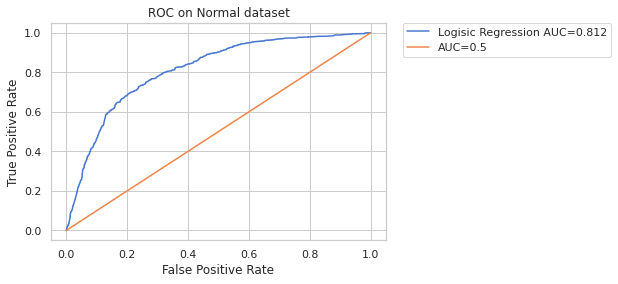

The log loss and auc was found to be 0.542 and 0.812 for Logisic Regression on Normal dataset.


In [10]:
i=0
labels=[] #storing all labels
y_preds = [] #storing all y_pred
y_pred = model.predict_proba(X_val)[:,1]
label="Logisic Regression"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label,dataset)
result_df = result
del result

# Decision Trees

In [ ]:
model = tree.DecisionTreeClassifier(class_weight='balanced')
params = { 
          'max_depth':[10,100,500,1000,-1], 
         'min_samples_split':[2,5,10,100,500], 
          'min_samples_leaf':[1,3,5,7,10],
          'max_leaf_nodes':[100,500,1000,5000,-1] 
          }


In [ ]:
%%time
find_best_params(model,params)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:  2.0min
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:  5.7min finished


The best auc score was 0.762
The best params were: {'min_samples_split': 5, 'min_samples_leaf': 10, 'max_leaf_nodes': 500, 'max_depth': 10}
CPU times: user 5.23 s, sys: 392 ms, total: 5.62 s
Wall time: 5min 44s


DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=500,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [11]:
model = tree.DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=500,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                      splitter='best')

model.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=500,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [12]:
cc_model = calibration.CalibratedClassifierCV(model,cv='prefit')
cc_model.fit(X_train,y_train)

CalibratedClassifierCV(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                             class_weight='balanced',
                                                             criterion='gini',
                                                             max_depth=10,
                                                             max_features=None,
                                                             max_leaf_nodes=500,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=10,
                                                             min_samples_split=5,
                                                             min_weight_fraction_leaf=0.0,
                                                             presort='deprecated',
           

		 Decision Tree Classifier on Normal dataset 		 



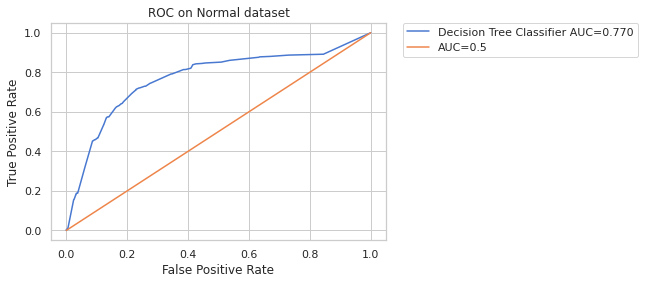

The log loss and auc was found to be 0.149 and 0.770 for Decision Tree Classifier on Normal dataset.


In [13]:
i+=1
y_pred = cc_model.predict_proba(X_val)[:,1]
label="Decision Tree Classifier"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [14]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Normal,0.541973,0.812374
1,Decision Tree Classifier,Normal,0.149154,0.769659


# Random Forest

In [ ]:
model = ensemble.RandomForestClassifier(class_weight='balanced')
params = { 'n_estimators':[500,1000,2000],
          'max_depth':[500,1000,2000], 
         'min_samples_split':[100,500,1000],
          'min_samples_leaf':[3,5,7],
          'max_leaf_nodes':[100,250,500] 
          }


In [ ]:
%%time
find_best_params(model,params,cv=3)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  27 out of  30 | elapsed: 54.3min remaining:  6.0min
[Parallel(n_jobs=10)]: Done  30 out of  30 | elapsed: 54.6min finished


The best auc score was 0.817
The best params were: {'n_estimators': 2000, 'min_samples_split': 500, 'min_samples_leaf': 3, 'max_leaf_nodes': 250, 'max_depth': 2000}
CPU times: user 6min 5s, sys: 1.17 s, total: 6min 6s
Wall time: 1h 44s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=2000, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [15]:
model = ensemble.RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=2000, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=10, oob_score=False,
                       verbose=0, warm_start=False)


model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=2000, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=10, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [16]:
cc_model = calibration.CalibratedClassifierCV(model,cv='prefit')
cc_model.fit(X_train,y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             ccp_alpha=0.0,
                                                             class_weight='balanced',
                                                             criterion='gini',
                                                             max_depth=2000,
                                                             max_features='auto',
                                                             max_leaf_nodes=250,
                                                             max_samples=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=3,
                                                             min_samples_split=500,
                        

		 Random Forest Classifier on Normal dataset 		 



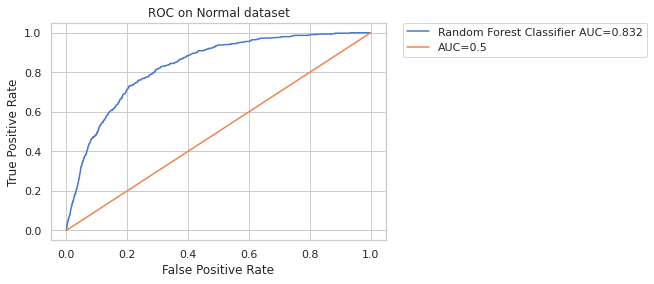

The log loss and auc was found to be 0.138 and 0.832 for Random Forest Classifier on Normal dataset.


In [17]:
i+=1
y_pred = cc_model.predict_proba(X_val)[:,1]
label="Random Forest Classifier"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [18]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Normal,0.541973,0.812374
1,Decision Tree Classifier,Normal,0.149154,0.769659
2,Random Forest Classifier,Normal,0.137582,0.832027


# Selecting top features

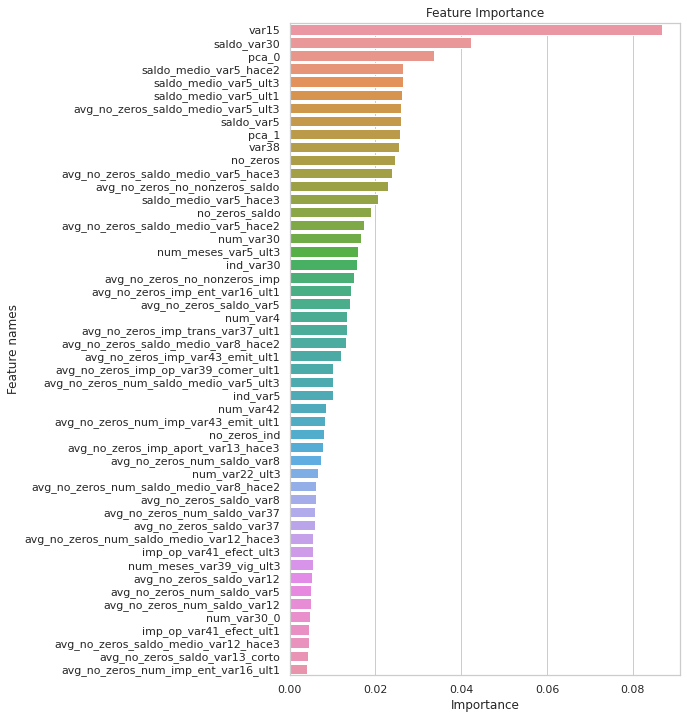

In [19]:
plot_feature_importance(X_train,model.feature_importances_,top=50,size=(7,12))

We will create new datasets with less features.

In [20]:
#getting features that have >=0.01 feature importance value.
top=0.01
features = get_top_features(X_train,model.feature_importances_,top=top)
print("There are %i features that have feature importance value above %.5f"%(len(features),top))
X_train_01 = X_train[features].copy()
X_val_01 = X_val[features].copy()
X_test_01 = X_test[features].copy()

There are 29 features that have feature importance value above 0.01000


In [21]:
#getting top k features
top=100
features = get_top_features(X_train,model.feature_importances_,top=top)
print("Taking top %i features"%(top))
X_train_100 = X_train[features].copy()
X_val_100 = X_val[features].copy()
X_test_100 = X_test[features].copy()

Taking top 100 features


In [22]:
#getting top k features
top=250
features = get_top_features(X_train,model.feature_importances_,top=top)
print("Taking top %i features"%(top))
X_train_200 = X_train[features].copy()
X_val_200 = X_val[features].copy()
X_test_200 = X_test[features].copy()

Taking top 250 features


# XGB Classifier

In [23]:
model = xgb.XGBClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1.,
                      learning_rate=0.01,  
                      colsample_bytree = 0.5,
                      subsample = 0.9,
                      objective='binary:logistic', 
                      n_estimators=1000,
                      reg_alpha = 0.3,
                      max_depth=5, 
                      gamma=5,random_state=42
                     )

In [24]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['error','auc']
%time model.fit(X_train,y_train,eval_set=[(X_val,y_val)],eval_metric=eval_metric,verbose=True)

[0]	validation_0-error:0.039551	validation_0-auc:0.789139
[1]	validation_0-error:0.039551	validation_0-auc:0.813043
[2]	validation_0-error:0.039551	validation_0-auc:0.819565
[3]	validation_0-error:0.039551	validation_0-auc:0.821249
[4]	validation_0-error:0.039551	validation_0-auc:0.821085
[5]	validation_0-error:0.039551	validation_0-auc:0.822364
[6]	validation_0-error:0.039551	validation_0-auc:0.823676
[7]	validation_0-error:0.039551	validation_0-auc:0.825374
[8]	validation_0-error:0.039551	validation_0-auc:0.82343
[9]	validation_0-error:0.039551	validation_0-auc:0.823638
[10]	validation_0-error:0.039551	validation_0-auc:0.823014
[11]	validation_0-error:0.039551	validation_0-auc:0.825491
[12]	validation_0-error:0.039551	validation_0-auc:0.824393
[13]	validation_0-error:0.039551	validation_0-auc:0.82442
[14]	validation_0-error:0.039551	validation_0-auc:0.823816
[15]	validation_0-error:0.039551	validation_0-auc:0.824531
[16]	validation_0-error:0.039551	validation_0-auc:0.824537
[17]	vali

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=5,
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=-1, objective='binary:logistic', random_state=42,
              reg_alpha=0.3, reg_lambda=1, scale_pos_weight=1.0, seed=None,
              silent=None, subsample=0.9, verbosity=1)

		 XGBoost Classifer on Normal dataset 		 



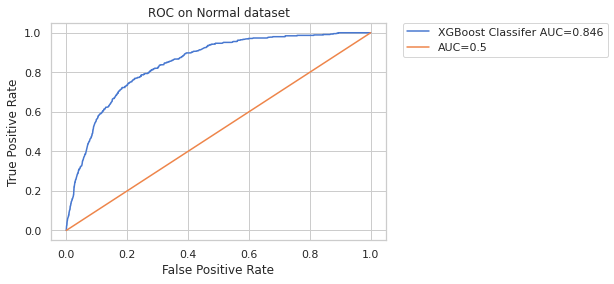

The log loss and auc was found to be 0.133 and 0.846 for XGBoost Classifer on Normal dataset.


In [25]:
y_pred = model.predict_proba(X_val)[:,1]
label="XGBoost Classifer"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [26]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Normal,0.541973,0.812374
1,Decision Tree Classifier,Normal,0.149154,0.769659
2,Random Forest Classifier,Normal,0.137582,0.832027
3,XGBoost Classifer,Normal,0.133134,0.845530


# LightGBM Classifier

In [27]:
model = lgb.LGBMClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1.,
                      learning_rate=0.01,  
                      colsample_bytree = 0.5,
                      subsample = 0.8,
                      objective='binary', 
                      n_estimators=1000,
                      reg_alpha = 0.3,
                      max_depth=7, 
                      random_state=42
                     )

In [28]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train,y_train,eval_set=[(X_val,y_val)],eval_metric=eval_metric,verbose=True)

[1]	valid_0's auc: 0.82222	valid_0's binary_logloss: 0.165705
[2]	valid_0's auc: 0.830939	valid_0's binary_logloss: 0.164968
[3]	valid_0's auc: 0.831899	valid_0's binary_logloss: 0.164336
[4]	valid_0's auc: 0.827044	valid_0's binary_logloss: 0.163821
[5]	valid_0's auc: 0.833475	valid_0's binary_logloss: 0.163172
[6]	valid_0's auc: 0.835122	valid_0's binary_logloss: 0.162512
[7]	valid_0's auc: 0.833434	valid_0's binary_logloss: 0.161947
[8]	valid_0's auc: 0.834585	valid_0's binary_logloss: 0.161304
[9]	valid_0's auc: 0.835732	valid_0's binary_logloss: 0.16071
[10]	valid_0's auc: 0.837555	valid_0's binary_logloss: 0.160145
[11]	valid_0's auc: 0.836925	valid_0's binary_logloss: 0.159696
[12]	valid_0's auc: 0.83787	valid_0's binary_logloss: 0.159196
[13]	valid_0's auc: 0.836422	valid_0's binary_logloss: 0.158757
[14]	valid_0's auc: 0.836331	valid_0's binary_logloss: 0.158296
[15]	valid_0's auc: 0.837381	valid_0's binary_logloss: 0.157794
[16]	valid_0's auc: 0.837436	valid_0's binary_loglos

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
               importance_type='split', learning_rate=0.01, max_depth=7,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=1000, n_jobs=-1, nthread=-1, num_leaves=31,
               objective='binary', random_state=42, reg_alpha=0.3,
               reg_lambda=0.0, scale_pos_weight=1.0, silent=True, subsample=0.8,
               subsample_for_bin=200000, subsample_freq=0)

		 LightGBM Classifer on Normal dataset 		 



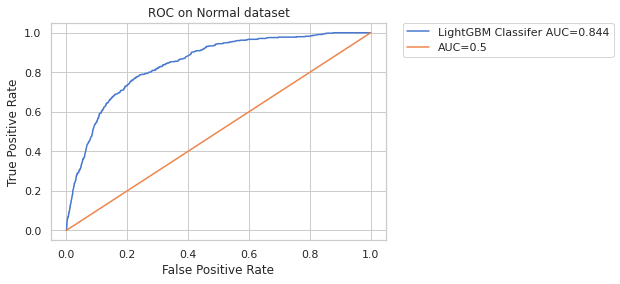

The log loss and auc was found to be 0.133 and 0.844 for LightGBM Classifer on Normal dataset.


In [29]:
y_pred = model.predict_proba(X_val)[:,1]
label="LightGBM Classifer"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [30]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Normal,0.541973,0.812374
1,Decision Tree Classifier,Normal,0.149154,0.769659
2,Random Forest Classifier,Normal,0.137582,0.832027
3,XGBoost Classifer,Normal,0.133134,0.845530
4,LightGBM Classifer,Normal,0.133040,0.844278


# Random Forest (feature importance>0.01)

In [ ]:
model = ensemble.RandomForestClassifier(class_weight='balanced')
params = { 'n_estimators':[1000,2000],
          'max_depth':[500,1000], 
         'min_samples_split':[100,500],
          'min_samples_leaf':[5,7],
          'max_leaf_nodes':[100,250] 
          }


In [ ]:
%%time
find_best_params(model,params,cv=3,X_train=X_train_01)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 34.5min finished


The best auc score was 0.820
The best params were: {'n_estimators': 2000, 'min_samples_split': 500, 'min_samples_leaf': 7, 'max_leaf_nodes': 250, 'max_depth': 500}
CPU times: user 3min 6s, sys: 437 ms, total: 3min 7s
Wall time: 37min 38s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=7, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [31]:
model = ensemble.RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=2000, max_features='auto',
                       max_leaf_nodes=100, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=7, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False,
                       verbose=0, warm_start=False)

model.fit(X_train_01,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=2000, max_features='auto',
                       max_leaf_nodes=100, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=7, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [32]:
cc_model = calibration.CalibratedClassifierCV(model,cv='prefit')
cc_model.fit(X_train_01,y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             ccp_alpha=0.0,
                                                             class_weight='balanced',
                                                             criterion='gini',
                                                             max_depth=2000,
                                                             max_features='auto',
                                                             max_leaf_nodes=100,
                                                             max_samples=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=7,
                                                             min_samples_split=500,
                        

		 Random Forest Classifier (feature importance>0.01) on Normal dataset 		 



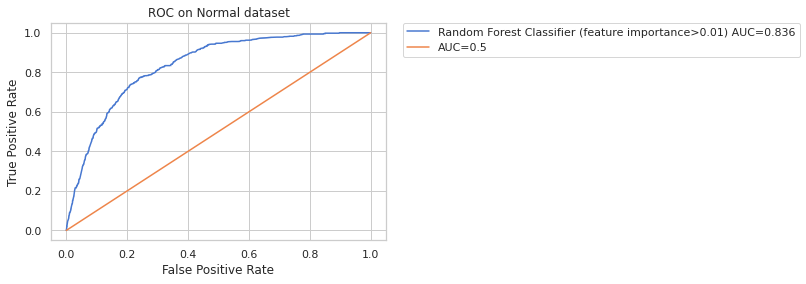

The log loss and auc was found to be 0.137 and 0.836 for Random Forest Classifier (feature importance>0.01) on Normal dataset.


In [33]:
i+=1
y_pred = cc_model.predict_proba(X_val_01)[:,1]
label="Random Forest Classifier (feature importance>0.01)"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label,dataset)
result_df = result_df.append(result)
del result

In [34]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Normal,0.541973,0.812374
1,Decision Tree Classifier,Normal,0.149154,0.769659
2,Random Forest Classifier,Normal,0.137582,0.832027
3,XGBoost Classifer,Normal,0.133134,0.845530
4,LightGBM Classifer,Normal,0.133040,0.844278
5,Random Forest Classifier (feature importance>0...,Normal,0.136733,0.835933


# XGB Classifier (feature importance>0.01)

In [35]:
model = xgb.XGBClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1.,
                      learning_rate=0.01,  
                      colsample_bytree = 0.8,
                      subsample = 0.9,
                      objective='binary:logistic', 
                      n_estimators=1000,
                      reg_alpha = 0.3,
                      max_depth=5, 
                      gamma=0.0,random_state=42
                     )

In [36]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train_01,y_train,eval_set=[(X_val_01,y_val)],eval_metric=eval_metric,verbose=True)

[0]	validation_0-auc:0.804211	validation_0-error:0.039639
[1]	validation_0-auc:0.809394	validation_0-error:0.039551
[2]	validation_0-auc:0.812478	validation_0-error:0.039551
[3]	validation_0-auc:0.813196	validation_0-error:0.039551
[4]	validation_0-auc:0.812968	validation_0-error:0.039551
[5]	validation_0-auc:0.813511	validation_0-error:0.039551
[6]	validation_0-auc:0.814092	validation_0-error:0.039551
[7]	validation_0-auc:0.814325	validation_0-error:0.039551
[8]	validation_0-auc:0.821769	validation_0-error:0.039551
[9]	validation_0-auc:0.821784	validation_0-error:0.039551
[10]	validation_0-auc:0.82183	validation_0-error:0.039551
[11]	validation_0-auc:0.822268	validation_0-error:0.039551
[12]	validation_0-auc:0.822332	validation_0-error:0.039551
[13]	validation_0-auc:0.822361	validation_0-error:0.039551
[14]	validation_0-auc:0.822217	validation_0-error:0.039551
[15]	validation_0-auc:0.822926	validation_0-error:0.039551
[16]	validation_0-auc:0.823532	validation_0-error:0.039551
[17]	val

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.0,
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=-1, objective='binary:logistic', random_state=42,
              reg_alpha=0.3, reg_lambda=1, scale_pos_weight=1.0, seed=None,
              silent=None, subsample=0.9, verbosity=1)

		 XGBoost Classifer(feature importance>0.01) on Normal dataset 		 



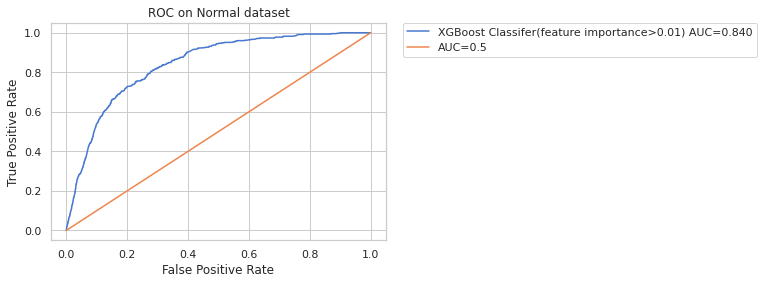

The log loss and auc was found to be 0.135 and 0.840 for XGBoost Classifer(feature importance>0.01) on Normal dataset.


In [37]:
y_pred = model.predict_proba(X_val_01)[:,1]
label="XGBoost Classifer(feature importance>0.01)"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [38]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Normal,0.541973,0.812374
1,Decision Tree Classifier,Normal,0.149154,0.769659
2,Random Forest Classifier,Normal,0.137582,0.832027
3,XGBoost Classifer,Normal,0.133134,0.845530
4,LightGBM Classifer,Normal,0.133040,0.844278
5,Random Forest Classifier (feature importance>0...,Normal,0.136733,0.835933
6,XGBoost Classifer(feature importance>0.01),Normal,0.134786,0.840104


# LightGBM Classifier (feature importance>0.01)

In [39]:
model = lgb.LGBMClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1.,
                      learning_rate=0.01,  
                      colsample_bytree = 0.8,
                      subsample = 0.8,
                      objective='binary', 
                      n_estimators=740,
                      reg_alpha = 0.3,
                      max_depth=7, 
                      gamma=5,random_state=42
                     )


In [40]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train_01,y_train,eval_set=[(X_val_01,y_val)],eval_metric=eval_metric,verbose=True)

[1]	valid_0's auc: 0.789355	valid_0's binary_logloss: 0.165847
[2]	valid_0's auc: 0.797184	valid_0's binary_logloss: 0.165217
[3]	valid_0's auc: 0.813615	valid_0's binary_logloss: 0.164541
[4]	valid_0's auc: 0.817104	valid_0's binary_logloss: 0.163904
[5]	valid_0's auc: 0.820745	valid_0's binary_logloss: 0.1633
[6]	valid_0's auc: 0.826194	valid_0's binary_logloss: 0.162651
[7]	valid_0's auc: 0.828299	valid_0's binary_logloss: 0.162051
[8]	valid_0's auc: 0.830139	valid_0's binary_logloss: 0.161448
[9]	valid_0's auc: 0.830664	valid_0's binary_logloss: 0.160935
[10]	valid_0's auc: 0.831255	valid_0's binary_logloss: 0.160397
[11]	valid_0's auc: 0.831548	valid_0's binary_logloss: 0.159878
[12]	valid_0's auc: 0.830898	valid_0's binary_logloss: 0.159469
[13]	valid_0's auc: 0.83095	valid_0's binary_logloss: 0.159018
[14]	valid_0's auc: 0.831395	valid_0's binary_logloss: 0.15853
[15]	valid_0's auc: 0.831942	valid_0's binary_logloss: 0.158054
[16]	valid_0's auc: 0.832445	valid_0's binary_logloss

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
               gamma=5, importance_type='split', learning_rate=0.01,
               max_depth=7, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=740, n_jobs=-1, nthread=-1,
               num_leaves=31, objective='binary', random_state=42,
               reg_alpha=0.3, reg_lambda=0.0, scale_pos_weight=1.0, silent=True,
               subsample=0.8, subsample_for_bin=200000, subsample_freq=0)

		 LightGBM Classifer (feature importance>0.01) on Normal dataset 		 



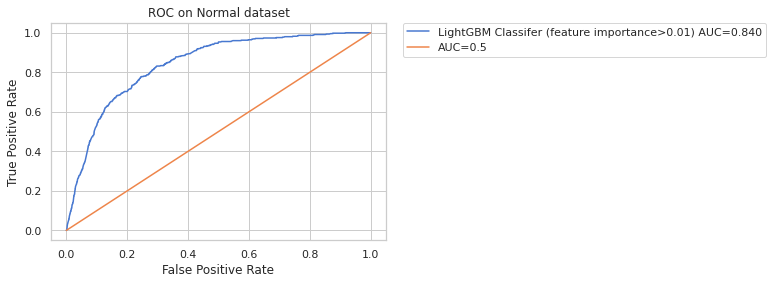

The log loss and auc was found to be 0.135 and 0.840 for LightGBM Classifer (feature importance>0.01) on Normal dataset.


In [41]:
y_pred = model.predict_proba(X_val_01)[:,1]
label="LightGBM Classifer (feature importance>0.01)"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [42]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Normal,0.541973,0.812374
1,Decision Tree Classifier,Normal,0.149154,0.769659
2,Random Forest Classifier,Normal,0.137582,0.832027
3,XGBoost Classifer,Normal,0.133134,0.845530
4,LightGBM Classifer,Normal,0.133040,0.844278
5,Random Forest Classifier (feature importance>0...,Normal,0.136733,0.835933
6,XGBoost Classifer(feature importance>0.01),Normal,0.134786,0.840104
7,LightGBM Classifer (feature importance>0.01),Normal,0.134797,0.840310


# Random Forest (top 100)

In [ ]:
model = ensemble.RandomForestClassifier(class_weight='balanced')
params = { 'n_estimators':[1000,2000],
          'max_depth':[500,1000], 
         'min_samples_split':[100,500],
          'min_samples_leaf':[3,5],
          'max_leaf_nodes':[100,250] 
          }


In [ ]:
%%time
find_best_params(model,params,cv=3,X_train=X_train_100)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 46.3min finished


The best auc score was 0.822
The best params were: {'n_estimators': 2000, 'min_samples_split': 500, 'min_samples_leaf': 5, 'max_leaf_nodes': 250, 'max_depth': 1000}
CPU times: user 4min 21s, sys: 1.65 s, total: 4min 23s
Wall time: 50min 38s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=1000, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [43]:
model = ensemble.RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=1000, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=-1, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

model.fit(X_train_100,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=1000, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [44]:
cc_model = calibration.CalibratedClassifierCV(model,cv='prefit')
cc_model.fit(X_train_100,y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             ccp_alpha=0.0,
                                                             class_weight='balanced',
                                                             criterion='gini',
                                                             max_depth=1000,
                                                             max_features='auto',
                                                             max_leaf_nodes=250,
                                                             max_samples=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=5,
                                                             min_samples_split=500,
                        

		 Random Forest Classifier (top 100) on Normal dataset 		 



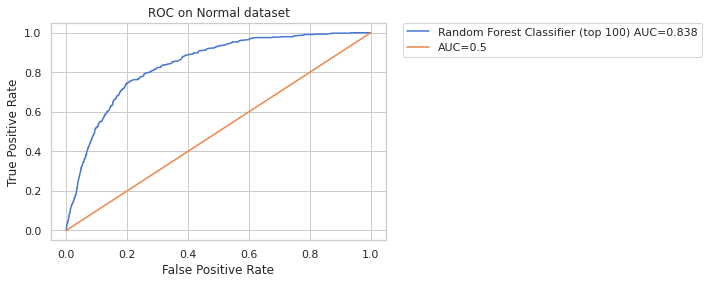

The log loss and auc was found to be 0.136 and 0.838 for Random Forest Classifier (top 100) on Normal dataset.


In [45]:
i+=1
y_pred = cc_model.predict_proba(X_val_100)[:,1]
label="Random Forest Classifier (top 100)"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label,dataset)
result_df = result_df.append(result)
del result

In [46]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Normal,0.541973,0.812374
1,Decision Tree Classifier,Normal,0.149154,0.769659
2,Random Forest Classifier,Normal,0.137582,0.832027
3,XGBoost Classifer,Normal,0.133134,0.845530
4,LightGBM Classifer,Normal,0.133040,0.844278
5,Random Forest Classifier (feature importance>0...,Normal,0.136733,0.835933
6,XGBoost Classifer(feature importance>0.01),Normal,0.134786,0.840104
7,LightGBM Classifer (feature importance>0.01),Normal,0.134797,0.840310
8,Random Forest Classifier (top 100),Normal,0.136017,0.838055


# XGB Classifier (top 100)

In [47]:
model = xgb.XGBClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1.,
                      learning_rate=0.01,  
                      colsample_bytree = 0.5,
                      subsample = 1,
                      objective='binary:logistic', 
                      n_estimators=845,
                      reg_alpha = 10,
                      max_depth=7, 
                      gamma=0,random_state=42
                     )


In [48]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train_100,y_train,eval_set=[(X_val_100,y_val)],eval_metric=eval_metric,verbose=True)

[0]	validation_0-auc:0.774141	validation_0-error:0.039551
[1]	validation_0-auc:0.783468	validation_0-error:0.039551
[2]	validation_0-auc:0.785502	validation_0-error:0.039551
[3]	validation_0-auc:0.778716	validation_0-error:0.039551
[4]	validation_0-auc:0.778547	validation_0-error:0.039551
[5]	validation_0-auc:0.779231	validation_0-error:0.039551
[6]	validation_0-auc:0.788076	validation_0-error:0.039551
[7]	validation_0-auc:0.788413	validation_0-error:0.039551
[8]	validation_0-auc:0.788968	validation_0-error:0.039551
[9]	validation_0-auc:0.789806	validation_0-error:0.039551
[10]	validation_0-auc:0.789198	validation_0-error:0.039551
[11]	validation_0-auc:0.789168	validation_0-error:0.039551
[12]	validation_0-auc:0.788547	validation_0-error:0.039551
[13]	validation_0-auc:0.789202	validation_0-error:0.039551
[14]	validation_0-auc:0.789325	validation_0-error:0.039551
[15]	validation_0-auc:0.78887	validation_0-error:0.039551
[16]	validation_0-auc:0.788531	validation_0-error:0.039551
[17]	val

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=845, n_jobs=-1,
              nthread=-1, objective='binary:logistic', random_state=42,
              reg_alpha=10, reg_lambda=1, scale_pos_weight=1.0, seed=None,
              silent=None, subsample=1, verbosity=1)

		 XGBoost Classifer(top 100) on Normal dataset 		 



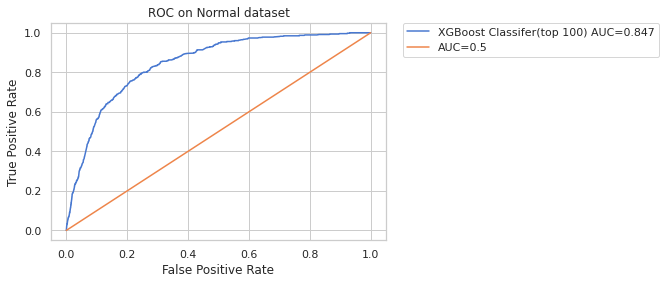

The log loss and auc was found to be 0.133 and 0.847 for XGBoost Classifer(top 100) on Normal dataset.


In [49]:
y_pred = model.predict_proba(X_val_100)[:,1]
label="XGBoost Classifer(top 100)"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [50]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Normal,0.541973,0.812374
1,Decision Tree Classifier,Normal,0.149154,0.769659
2,Random Forest Classifier,Normal,0.137582,0.832027
3,XGBoost Classifer,Normal,0.133134,0.845530
4,LightGBM Classifer,Normal,0.133040,0.844278
5,Random Forest Classifier (feature importance>0...,Normal,0.136733,0.835933
6,XGBoost Classifer(feature importance>0.01),Normal,0.134786,0.840104
7,LightGBM Classifer (feature importance>0.01),Normal,0.134797,0.840310
8,Random Forest Classifier (top 100),Normal,0.136017,0.838055
9,XGBoost Classifer(top 100),Normal,0.132992,0.846820


# LightGBM Classifier (top 100)

In [51]:
model = lgb.LGBMClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1.,
                      learning_rate=0.01,  
                      colsample_bytree = 0.6,
                      subsample = 1,
                      objective='binary', 
                      n_estimators=601,
                      reg_alpha = 0.4,
                      max_depth=6, 
                      gamma=10,random_state=42
                     )

In [52]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train_100,y_train,eval_set=[(X_val_100,y_val)],eval_metric=eval_metric,verbose=True)

[1]	valid_0's auc: 0.789261	valid_0's binary_logloss: 0.165861
[2]	valid_0's auc: 0.800924	valid_0's binary_logloss: 0.165185
[3]	valid_0's auc: 0.819337	valid_0's binary_logloss: 0.164481
[4]	valid_0's auc: 0.827886	valid_0's binary_logloss: 0.163825
[5]	valid_0's auc: 0.829659	valid_0's binary_logloss: 0.163187
[6]	valid_0's auc: 0.82832	valid_0's binary_logloss: 0.162608
[7]	valid_0's auc: 0.826138	valid_0's binary_logloss: 0.162059
[8]	valid_0's auc: 0.828741	valid_0's binary_logloss: 0.161464
[9]	valid_0's auc: 0.829304	valid_0's binary_logloss: 0.160902
[10]	valid_0's auc: 0.828319	valid_0's binary_logloss: 0.160468
[11]	valid_0's auc: 0.82708	valid_0's binary_logloss: 0.160028
[12]	valid_0's auc: 0.826938	valid_0's binary_logloss: 0.159574
[13]	valid_0's auc: 0.828627	valid_0's binary_logloss: 0.1591
[14]	valid_0's auc: 0.829753	valid_0's binary_logloss: 0.158623
[15]	valid_0's auc: 0.831201	valid_0's binary_logloss: 0.158152
[16]	valid_0's auc: 0.831903	valid_0's binary_logloss

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.6,
               gamma=10, importance_type='split', learning_rate=0.01,
               max_depth=6, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=601, n_jobs=-1, nthread=-1,
               num_leaves=31, objective='binary', random_state=42,
               reg_alpha=0.4, reg_lambda=0.0, scale_pos_weight=1.0, silent=True,
               subsample=1, subsample_for_bin=200000, subsample_freq=0)

		 LightGBM Classifer(top 100) on Normal dataset 		 



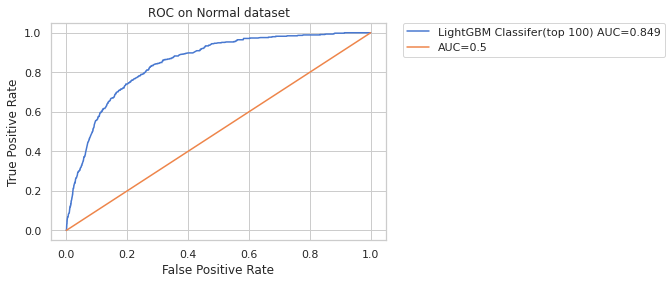

The log loss and auc was found to be 0.132 and 0.849 for LightGBM Classifer(top 100) on Normal dataset.


In [53]:
y_pred = model.predict_proba(X_val_100)[:,1]
label="LightGBM Classifer(top 100)"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

# Random Forest (top 250)

In [ ]:
model = ensemble.RandomForestClassifier(class_weight='balanced')
params = { 'n_estimators':[1000,2000],
          'max_depth':[500,1000], 
         'min_samples_split':[100,500],
          'min_samples_leaf':[5,7],
          'max_leaf_nodes':[100,250] 
          }


In [ ]:
%%time
find_best_params(model,params,cv=3,X_train=X_train_200)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 60.3min finished


The best auc score was 0.818
The best params were: {'n_estimators': 1000, 'min_samples_split': 500, 'min_samples_leaf': 5, 'max_leaf_nodes': 250, 'max_depth': 500}
CPU times: user 2min 44s, sys: 477 ms, total: 2min 45s
Wall time: 1h 3min 1s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [54]:
model = ensemble.RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
model.fit(X_train_200,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [55]:
cc_model = calibration.CalibratedClassifierCV(model,cv='prefit')
cc_model.fit(X_train_200,y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             ccp_alpha=0.0,
                                                             class_weight='balanced',
                                                             criterion='gini',
                                                             max_depth=500,
                                                             max_features='auto',
                                                             max_leaf_nodes=250,
                                                             max_samples=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=5,
                                                             min_samples_split=500,
                         

		 Random Forest Classifier (top 250) on Normal dataset 		 



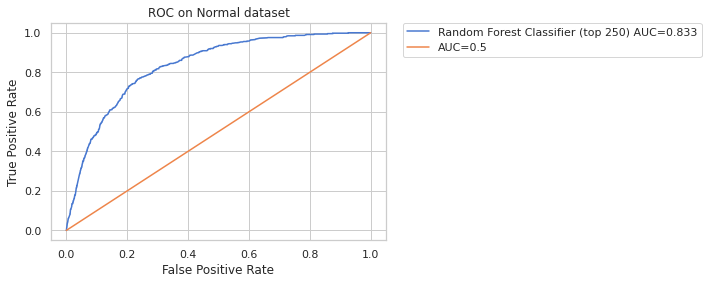

The log loss and auc was found to be 0.137 and 0.833 for Random Forest Classifier (top 250) on Normal dataset.


In [56]:
i+=1
y_pred = cc_model.predict_proba(X_val_200)[:,1]
label="Random Forest Classifier (top 250)"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label,dataset)
result_df = result_df.append(result)
del result

In [57]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Normal,0.541973,0.812374
1,Decision Tree Classifier,Normal,0.149154,0.769659
2,Random Forest Classifier,Normal,0.137582,0.832027
3,XGBoost Classifer,Normal,0.133134,0.845530
4,LightGBM Classifer,Normal,0.133040,0.844278
5,Random Forest Classifier (feature importance>0...,Normal,0.136733,0.835933
6,XGBoost Classifer(feature importance>0.01),Normal,0.134786,0.840104
7,LightGBM Classifer (feature importance>0.01),Normal,0.134797,0.840310
8,Random Forest Classifier (top 100),Normal,0.136017,0.838055
9,XGBoost Classifer(top 100),Normal,0.132992,0.846820


# XGB Classifier (top 250)

In [58]:
model = xgb.XGBClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.8, 
                      subsample = 0.7,
                      objective='binary:logistic', 
                      n_estimators=801,
                      reg_alpha = 0.3,
                      max_depth=6, 
                      gamma=0,random_state=42
                     )

In [59]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train_200,y_train,eval_set=[(X_val_200,y_val)],eval_metric=eval_metric,verbose=True)

[0]	validation_0-auc:0.786916	validation_0-error:0.040253
[1]	validation_0-auc:0.790141	validation_0-error:0.040077
[2]	validation_0-auc:0.792642	validation_0-error:0.039902
[3]	validation_0-auc:0.806727	validation_0-error:0.039551
[4]	validation_0-auc:0.812943	validation_0-error:0.039551
[5]	validation_0-auc:0.818697	validation_0-error:0.039551
[6]	validation_0-auc:0.820719	validation_0-error:0.039551
[7]	validation_0-auc:0.821186	validation_0-error:0.039551
[8]	validation_0-auc:0.823752	validation_0-error:0.039551
[9]	validation_0-auc:0.82447	validation_0-error:0.039551
[10]	validation_0-auc:0.824662	validation_0-error:0.039551
[11]	validation_0-auc:0.822299	validation_0-error:0.039551
[12]	validation_0-auc:0.824384	validation_0-error:0.039551
[13]	validation_0-auc:0.821911	validation_0-error:0.039551
[14]	validation_0-auc:0.823021	validation_0-error:0.039551
[15]	validation_0-auc:0.825378	validation_0-error:0.039551
[16]	validation_0-auc:0.825728	validation_0-error:0.039551
[17]	val

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=801, n_jobs=-1,
              nthread=-1, objective='binary:logistic', random_state=42,
              reg_alpha=0.3, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.7, verbosity=1)

		 XGBoost Classifer(top 250) on Normal dataset 		 



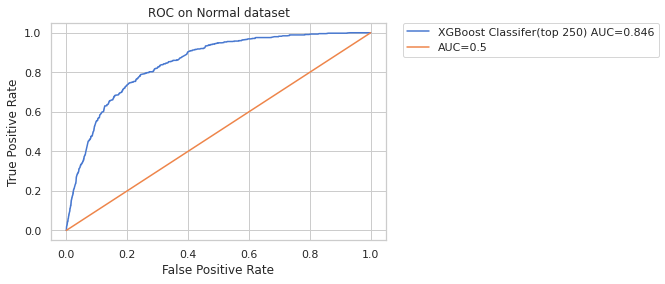

The log loss and auc was found to be 0.133 and 0.846 for XGBoost Classifer(top 250) on Normal dataset.


In [60]:
y_pred = model.predict_proba(X_val_200)[:,1]
label="XGBoost Classifer(top 250)"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [61]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Normal,0.541973,0.812374
1,Decision Tree Classifier,Normal,0.149154,0.769659
2,Random Forest Classifier,Normal,0.137582,0.832027
3,XGBoost Classifer,Normal,0.133134,0.845530
4,LightGBM Classifer,Normal,0.133040,0.844278
5,Random Forest Classifier (feature importance>0...,Normal,0.136733,0.835933
6,XGBoost Classifer(feature importance>0.01),Normal,0.134786,0.840104
7,LightGBM Classifer (feature importance>0.01),Normal,0.134797,0.840310
8,Random Forest Classifier (top 100),Normal,0.136017,0.838055
9,XGBoost Classifer(top 100),Normal,0.132992,0.846820


# LightGBM Classifier (top 250)

In [62]:
model = lgb.LGBMClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.5,
                      subsample = 0.8,
                      objective='binary', 
                      n_estimators=681,
                      reg_alpha = 1,
                      max_depth=9, random_state=42
                     )

In [63]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train_200,y_train,eval_set=[(X_val_200,y_val)],eval_metric=eval_metric,verbose=True)

[1]	valid_0's auc: 0.792756	valid_0's binary_logloss: 0.16584
[2]	valid_0's auc: 0.816306	valid_0's binary_logloss: 0.165183
[3]	valid_0's auc: 0.816507	valid_0's binary_logloss: 0.164548
[4]	valid_0's auc: 0.820155	valid_0's binary_logloss: 0.16395
[5]	valid_0's auc: 0.819972	valid_0's binary_logloss: 0.163404
[6]	valid_0's auc: 0.822805	valid_0's binary_logloss: 0.162759
[7]	valid_0's auc: 0.827943	valid_0's binary_logloss: 0.162146
[8]	valid_0's auc: 0.826818	valid_0's binary_logloss: 0.161604
[9]	valid_0's auc: 0.825142	valid_0's binary_logloss: 0.161115
[10]	valid_0's auc: 0.826924	valid_0's binary_logloss: 0.160575
[11]	valid_0's auc: 0.828107	valid_0's binary_logloss: 0.160027
[12]	valid_0's auc: 0.830053	valid_0's binary_logloss: 0.15951
[13]	valid_0's auc: 0.829348	valid_0's binary_logloss: 0.159059
[14]	valid_0's auc: 0.828665	valid_0's binary_logloss: 0.158626
[15]	valid_0's auc: 0.829008	valid_0's binary_logloss: 0.158217
[16]	valid_0's auc: 0.830181	valid_0's binary_loglos

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
               importance_type='split', learning_rate=0.01, max_depth=9,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=681, n_jobs=-1, nthread=-1, num_leaves=31,
               objective='binary', random_state=42, reg_alpha=1, reg_lambda=0.0,
               scale_pos_weight=1, silent=True, subsample=0.8,
               subsample_for_bin=200000, subsample_freq=0)

		 LightGBM Classifer(top 250) on Normal dataset 		 



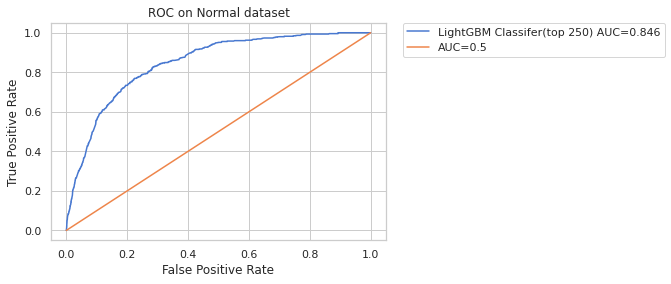

The log loss and auc was found to be 0.133 and 0.846 for LightGBM Classifer(top 250) on Normal dataset.


In [64]:
y_pred = model.predict_proba(X_val_200)[:,1]
label="LightGBM Classifer(top 250)"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

# Combined

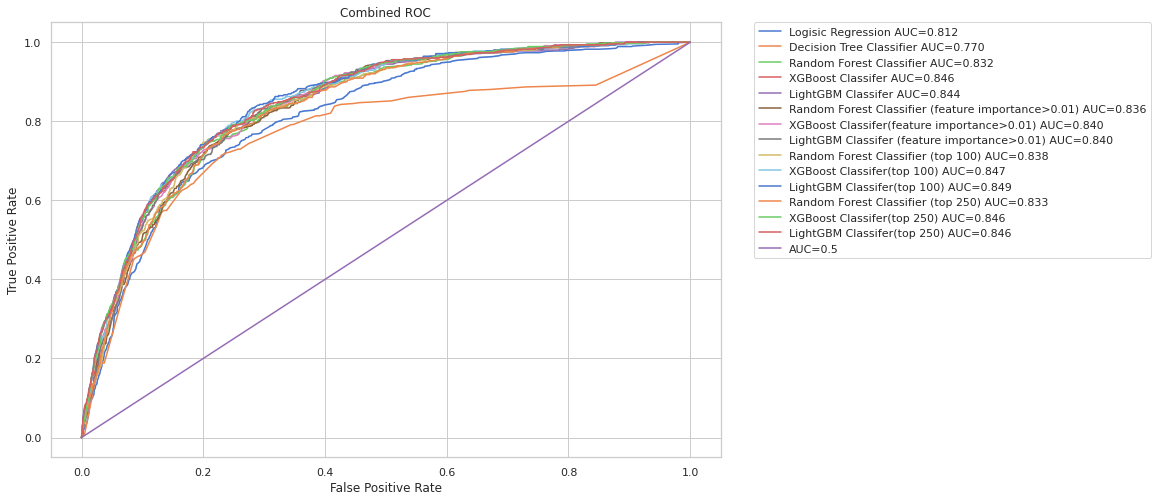

In [65]:
plot_auc(y_val,y_preds,labels)

In [66]:
result_df.sort_values(by='auc',ascending=False)

,Model,Dataset,log_loss,auc
10,LightGBM Classifer(top 100),Normal,0.132311,0.849349
9,XGBoost Classifer(top 100),Normal,0.132992,0.846820
13,LightGBM Classifer(top 250),Normal,0.132912,0.846089
12,XGBoost Classifer(top 250),Normal,0.133110,0.846031
3,XGBoost Classifer,Normal,0.133134,0.845530
4,LightGBM Classifer,Normal,0.133040,0.844278
7,LightGBM Classifer (feature importance>0.01),Normal,0.134797,0.840310
6,XGBoost Classifer(feature importance>0.01),Normal,0.134786,0.840104
8,Random Forest Classifier (top 100),Normal,0.136017,0.838055
5,Random Forest Classifier (feature importance>0...,Normal,0.136733,0.835933


# Saving all the datasets created

In [70]:
import joblib
filename = 'normal_train_100.pkl'
X_train_100.to_pickle(os.path.join(file_path,'best_models',filename))

filename = 'normal_val_100.pkl'
X_val_100.to_pickle(os.path.join(file_path,'best_models',filename))

filename = 'normal_test_100.pkl'
X_test_100.to_pickle(os.path.join(file_path,'best_models',filename))

filename = 'normal_train_250.pkl'
X_train_200.to_pickle(os.path.join(file_path,'best_models',filename))

filename = 'normal_val_250.pkl'
X_val_200.to_pickle(os.path.join(file_path,'best_models',filename))

filename = 'normal_test_250.pkl'
X_test_200.to_pickle(os.path.join(file_path,'best_models',filename))

filename = 'normal_train_01.pkl'
X_train_01.to_pickle(os.path.join(file_path,'best_models',filename))

filename = 'normal_val_01.pkl'
X_val_01.to_pickle(os.path.join(file_path,'best_models',filename))

filename = 'normal_test_01.pkl'
X_test_01.to_pickle(os.path.join(file_path,'best_models',filename))